### Every-visit Monte Carlo with Exploring Starts for estimating an optimal Blackjack policy

This corresponds to the algorithm described in Chapter 5.3 of [_Reinforcement Learning: An Introduction_](http://incompleteideas.net/book/the-book-2nd.html), by Sutton and Barto.

In [5]:
import pickle
import time

import gym
import numpy as np
from tqdm import tqdm

from rl_agents.blackjack.MonteCarloAgent import MonteCarloAgent

### Initialize Blackjack agent and environment

In [6]:
RANDOM_SEED = 2

env = gym.make('Blackjack-v0')
env.seed(seed=RANDOM_SEED)
agent = MonteCarloAgent(action_space=env.action_space,
                        obs_space=env.observation_space,
                        seed=RANDOM_SEED)

### Run Experiment

In [34]:
NUM_EPISODES = 10000000  # Train on 10000000 games of blackjack

for i_episode in tqdm(range(NUM_EPISODES)):
    observation = env.reset()
    reward = 0
    done = False
    t = 0
    episode_ts = []
    while not done:
        action = agent.agent_step(reward=reward,
                                  observation=observation)

        observation, reward, done, info = env.step(action)

        episode_ts.append((action, observation, reward))

        if done:
            break

        t += 1

    agent.agent_end(episode_ts=episode_ts)

100%|██████████| 10000000/10000000 [07:31<00:00, 22148.80it/s]


In [35]:
# Save the agent
with open("/home/protoman/dev/rl_agents/rl_agents/blackjack/agents/{}_mc_episodes={}.pkl".format(int(time.time()), NUM_EPISODES), "wb") as fp:
    pickle.dump(agent, fp)

### Analyze agent performance

In [116]:
# Dependencies
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
plt.rcParams['figure.figsize'] = [10, 10]

# Task specific plot labels
x_labels = ["A", "2", "3", "4", "5", "6", "7", "8", "9", "10"]
x_title = "Dealer Showing"
y_labels = ["11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21"]
y_title = "Player Sum"
z_title = "State Value"

# Visualization routines
def surface_plot(X, Y, Z, title):
    fig = plt.figure()
    ax = fig.gca(projection="3d")
    
    surface = ax.plot_surface(X, Y, Z, 
                              cmap=cm.coolwarm, 
                              linewidth=0, 
                              antialiased=False)
    
    # Add a color bar to make the plot a bit easier to read
#     cbar = fig.colorbar(surface, shrink=0.5, aspect=5)
    cbar = fig.colorbar(surface)
    cbar.ax.set_title("State Value Estimate", fontsize=14)
    
    # Rotate axis
    ax.view_init(elev=20, azim=220)
    
    # Labels & Titles
    ax.set_xticklabels(x_labels)
    ax.set_xlabel(x_title, fontsize=14)
    ax.set_yticklabels(y_labels)
    ax.set_ylabel(y_title, fontsize=14)
    ax.set_title(title, fontsize=16)
    
    plt.show()
    
def gen_heatmap(values, x_labels, y_labels, x_title, y_title, title):
    fig, ax = plt.subplots()
    
    heatmap = ax.pcolor(values)
    cbar = plt.colorbar(heatmap)
    cbar.ax.set_title("HIT prob", fontsize=14)

    # Labels & Titles
    ax.set_xticks(np.arange(len(x_labels))+1.0)
    ax.set_yticks(np.arange(len(y_labels))+1.0)
    ax.set_xticklabels(x_labels)
    ax.set_xlabel(x_title, fontsize=14)
    ax.set_yticklabels(y_labels)
    ax.set_ylabel(y_title, fontsize=14)
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.set_title(title, fontsize=16)
    
    # Add padding to color bar
    
    fig.tight_layout()
    plt.show()

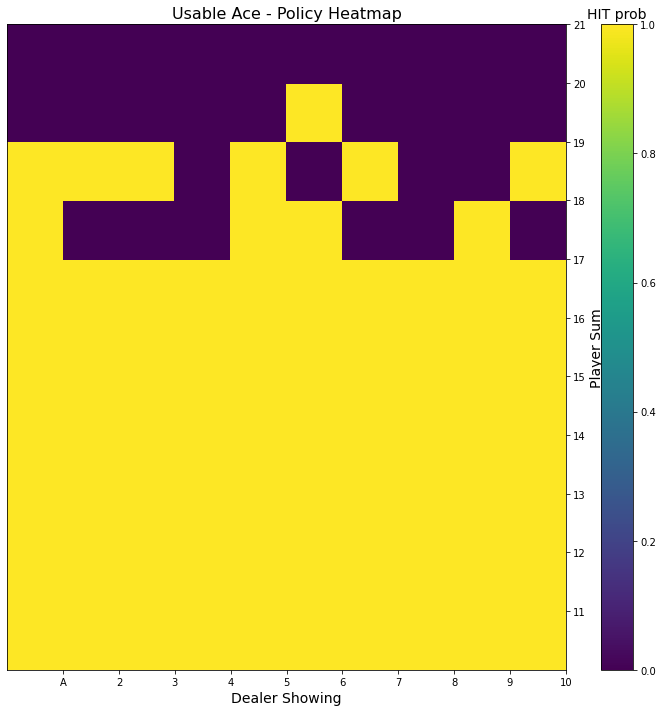

In [117]:
# Usable Ace - Policy Heatmap
policy_values = agent.policy[11:22, 1:, 1]
gen_heatmap(policy_values, x_labels, y_labels, x_title, y_title, "Usable Ace - Policy Heatmap")

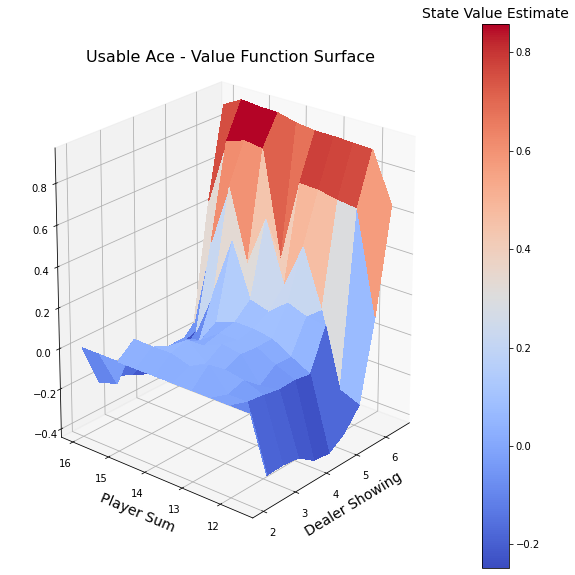

In [118]:
# Usable Ace - Value function surface
x = np.arange(12, 22)
y = np.arange(1, 11)

X, Y = np.meshgrid(x, y)

# Estimate the value function by following our deterministic action-value maximizing policy
Z = np.amax(agent.action_values[X, Y, 1], axis=2)

surface_plot(X=X, Y=Y, Z=Z, title="Usable Ace - Value Function Surface")

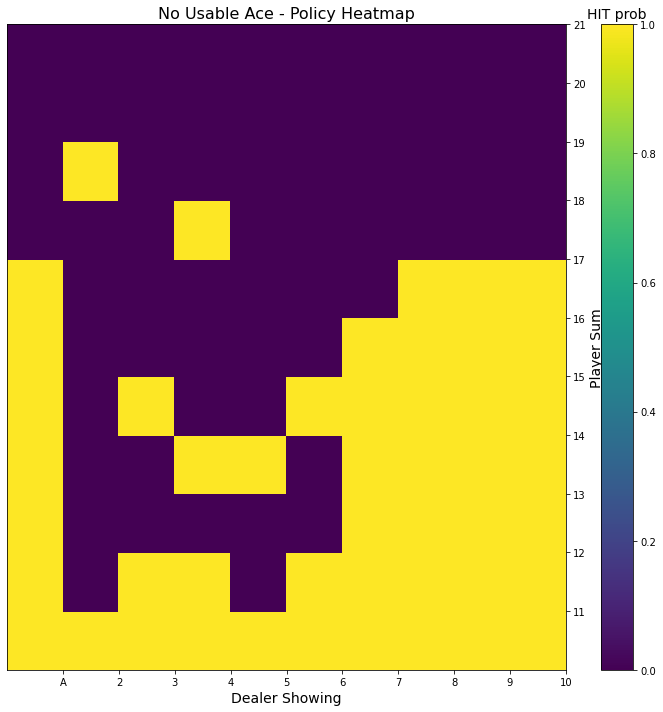

In [119]:
# No Usable Ace - Policy Heatmap
policy_values = agent.policy[11:22, 1:, 0]
gen_heatmap(policy_values, x_labels, y_labels, x_title, y_title, "No Usable Ace - Policy Heatmap")

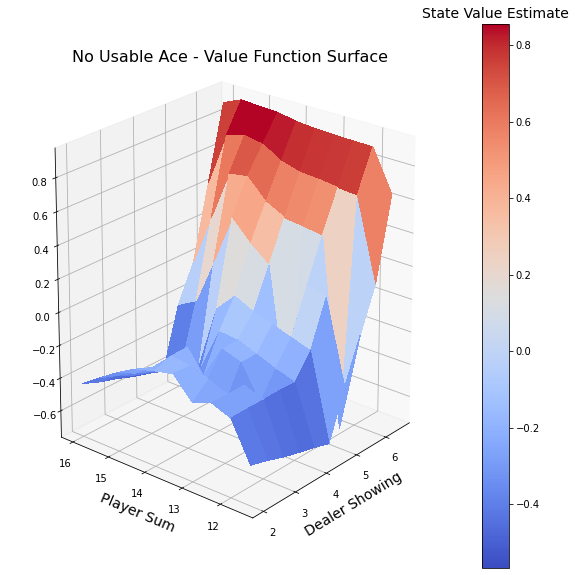

In [120]:
# No Usable Ace - Value function surface
x = np.arange(12, 22)
y = np.arange(1, 11)

X, Y = np.meshgrid(x, y)

# Estimate the value function by following our deterministic action-value maximizing policy
Z = np.amax(agent.action_values[X, Y, 0], axis=2)

surface_plot(X=X, Y=Y, Z=Z, title="No Usable Ace - Value Function Surface")

### TODO
- Investigate anomalies (e.g. agent.action_values[19, 2, 0])
- Consider "first-visit" instead of "every-visit" approach to reduce noisey updates?
- Clean up agent by removing unused memory
- Consider refactoring the experiment code to a module (and adding some quality of life stuff, like saving the agent periodically)